In [1]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import argparse
import pandas as pd
import nibabel as nib
import nilearn as nil
import seaborn as sns
import statsmodels.stats.multitest as smm

In [40]:
#importing the data from the csv file in the folder second_level_results
os.environ["ROOTDIR"] = r'C:\Users\angel\Documents\INPD_neuroimages_CAPE'  # seth path

workdir = os.environ["ROOTDIR"]
secondlvresults  = os.path.join(workdir,"second_level_results")

# shaeffer_network = pd.read_csv('tpl-MNI152NLin2009cAsym_atlas-Schaefer2018_desc-100Parcels7Networks_dseg.tsv', delimiter='\t')
# #extract the index with the name with SalVentAttn - salience network
# salience_index = shaeffer_network[shaeffer_network['name'].str.contains('SalVentAttn')]
# #extract the index with the name with Default - default mode network
# default_index = shaeffer_network[shaeffer_network['name'].str.contains('Default')]

seednames = ['DCPutamen',
            'DorsalCaudate',
            'DRPutamen',
            'InfVentralCaudate',
            'SupVentralCaudate',
            'VRPutamen'
            ]

# setting the seed name and the rois which had results in the second level analysis
seed = 'DRPutamen'
rois_tot = [42, 43, 44, 46, 98, 99]
rois_pa = [44, 94, 98]

#stat a dictionary to store the salience and default values
results = {}
tmap = {}

for cape in ['cape_PA_score', 'cape_tot']:

    # loading cape PA score results
    if cape == 'cape_PA_score':
        results[cape] = {}
        for roi in rois_pa:
            results[cape][roi] = pd.read_csv(os.path.join(secondlvresults,f'{cape}-{seed}-roi_{roi}_2ndlvl.csv'), index_col=0)
    
    # loading cape tot results
    elif cape == 'cape_tot':
        results[cape] = {}
        for roi in rois_tot:
            results[cape][roi] = pd.read_csv(os.path.join(secondlvresults,f'{cape}-{seed}-roi_{roi}_2ndlvl.csv'), index_col=0)

for seed in seednames:
    # loading the tmap results  
    tmap[f'{seed}'] = pd.read_csv(os.path.join(secondlvresults,f"{seed}_data-2ndlvl.csv"), index_col=0, header=0)


## Cape total results

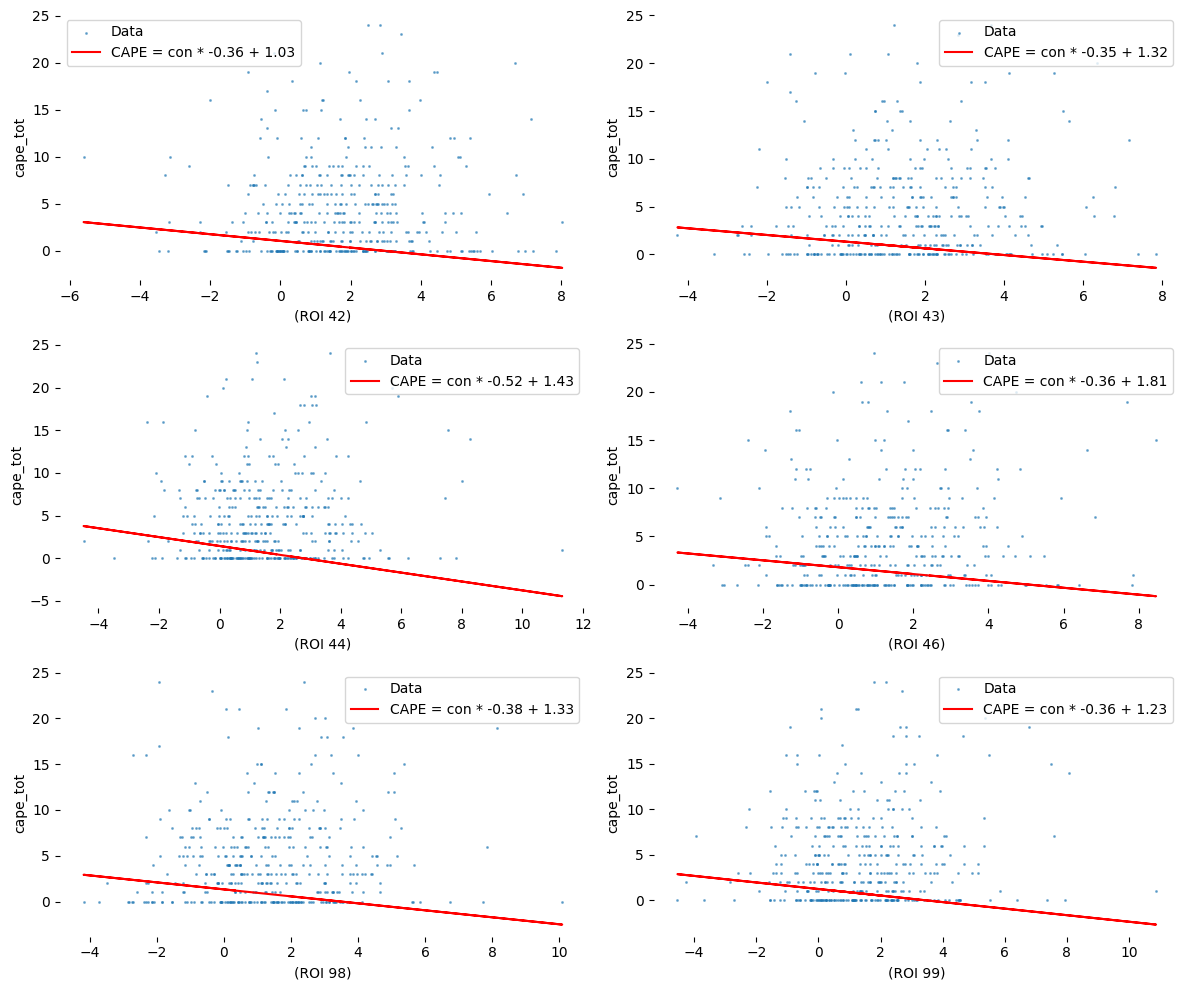

In [57]:
plt.figure(figsize=(30/2.5 , 25/2.5)) 

#plotting for CAPE total
cape = 'cape_tot'
seed = 'DCPutamen'
var_dep = tmap[f'{seed}'][f'{cape}'] # dependent variable (CAPE score)


for ind, roi in enumerate(rois_tot): 
    var_ind = tmap[f'{seed}'][f'roi_{roi}'] # independent variable (ROI connectivity)   

    plt.subplot(3 , 2, ind+1)
    # Scatter plot of ROI connectivity and CAPE Total
    plt.scatter(
        var_ind, 
        var_dep, 
        label='Data',
        s=5,
        marker='.',
        alpha=0.5,
    )

    # Plot regression line
    plt.plot(
        var_ind, 
        var_ind* results[f'{cape}'][roi]['coef'].values[0] + results[f'{cape}'][roi]['intercept'].values[0],
        color='red', 
        label=f'CAPE = con * {results[f'{cape}'][roi]['coef'].values[0]:.2f} + {results[f'{cape}'][roi]['intercept'].values[0]:.2f}'
    )

    # Add labels, title, and legend
    # plt.ylim(-1,25)
    plt.xlabel(f'(ROI {roi})')
    plt.ylabel(f'{cape}')
    plt.legend()

    ax = plt.gca()  # Get the current axis
    ax.spines['top'].set_visible(False)  # Hide the top spine
    ax.spines['right'].set_visible(False)  # Hide the right spine
    ax.spines['left'].set_visible(False)  # Hide the left spine
    ax.spines['bottom'].set_visible(False)  # Hide the bottom spine

        
    # Remove axis and contour lines
    # plt.axis('off')  # Turn off the axis
    ax = plt.gca()  # Get the current axis
    ax.spines['top'].set_visible(False)  # Hide the top spine
    ax.spines['right'].set_visible(False)  # Hide the right spine
    ax.spines['left'].set_visible(False)  # Hide the left spine
    ax.spines['bottom'].set_visible(False)  # Hide the bottom spine
    # ax.lines[0].set_visible(False)  # Hide the first line (scatter plot)
    # ax.xaxis.set_ticks([])  # Hide x-axis ticks
    # ax.yaxis.set_ticks([])  # Hide y-axis ticks
    plt.tight_layout()

# Show the plot
plt.show()

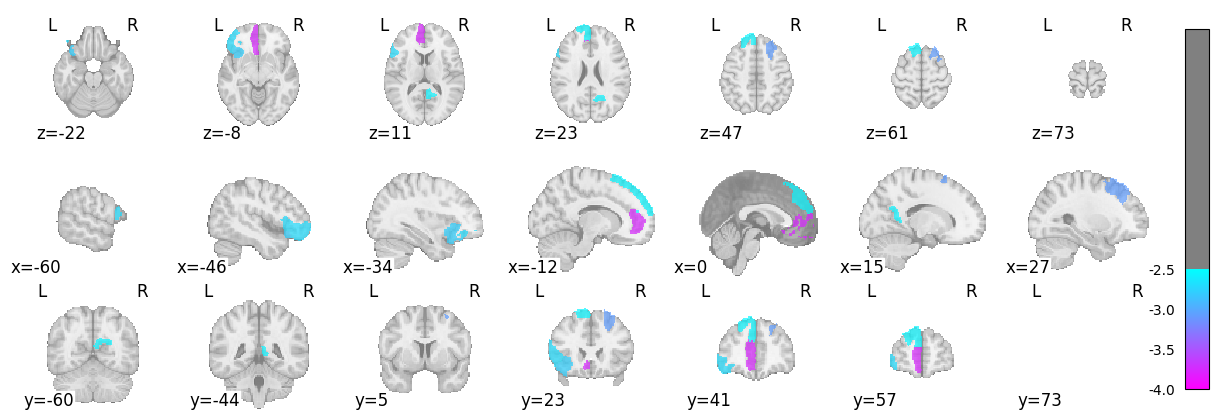

In [58]:
#create plots witt the t maps of the salience and default values in the brain
from templateflow.api import get
from nilearn.plotting import plot_roi, plot_anat    

atlas_name = 'Schaefer2018'
desc_name = '100Parcels7Networks'


atlas_file = get('MNI152NLin2009cAsym',
resolution=2,
atlas= atlas_name,
desc= desc_name
)
# Load the atlas using nibabel
atlas = nib.load(atlas_file)

# Step 1: create zero image
masks = np.zeros(np.shape(atlas), dtype=np.float32)

# Step 2: Use the affine matrix from the atlas
affine = atlas.affine

atlas_data = atlas.get_fdata()  # Use get_fdata() instead of get_data()

for roi_id in rois_tot:

    # Step 3: Find the indices where the atlas has the ROI ID
    ix = np.where(atlas_data == roi_id)  # ROI ID in atlas

    t_value = results[f'{cape}'][roi_id]['t_value']
    if isinstance(t_value, pd.Series):  # If it's a Series, extract the first value
        t_value = t_value.iloc[0]
    t_value = float(t_value)  # Ensure it is a float

    # 4. Assign the t-value to the corresponding voxels in the mask
    masks[ix] = t_value

# Step 5: Create a NIfTI image using the modified zero_volume
tmap_affined = nib.Nifti1Image(masks, affine)

# Step 6: Plot the tmap in the brain
fig, ax = plt.subplots(figsize=(30/2.5, 10/2.5))  # Create a Matplotlib figure
display = plot_roi(
    tmap_affined,
    display_mode='mosaic',
    colorbar=True,
    vmin=-4,
    vmax=-2.5,
    cmap='cool_r',  # Color map for the t-map
    figure=fig  # Pass the Matplotlib figure
)

# Step 7: Customize the color bar
cbar = plt.gcf().get_axes()[-1]  # Get the color bar axis (last axis in the figure)
cbar.set_yticks([-4, -3.5, -3, -2.5])  # Set custom tick values
cbar.set_yticklabels(['-4.0', '-3.5', '-3.0', '-2.5'])  # Set custom tick labels

ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['left'].set_visible(False)  # Hide the left spine
ax.spines['bottom'].set_visible(False)  # Hide the bottom spine
ax.xaxis.set_ticks([])  # Hide x-axis ticks
ax.yaxis.set_ticks([])  # Hide y-axis ticks

# Show the plot
plt.show()

## Cape PA

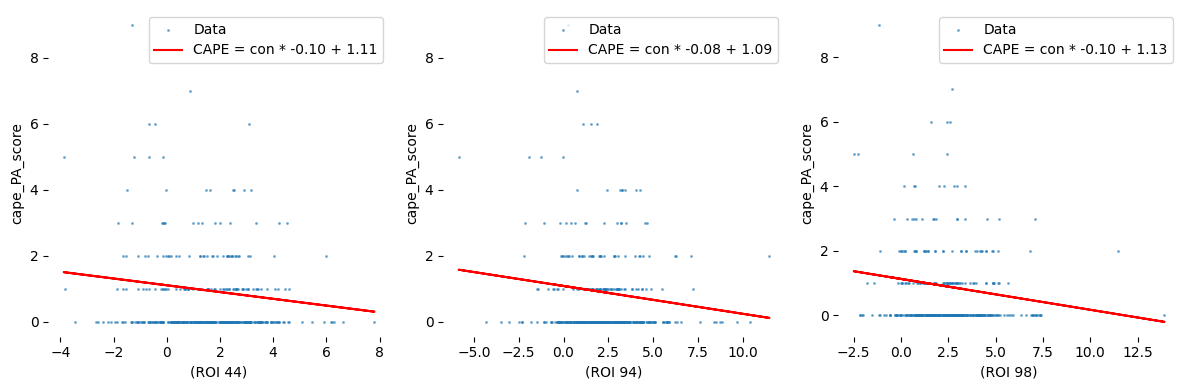

In [43]:
plt.figure(figsize=(30/2.5 , 10/2.5)) 

#plotting for CAPE total
cape = 'cape_PA_score'
seed = 'DRPutamen'
var_dep = tmap[f'{seed}'][f'{cape}'] # dependent variable (CAPE score)

for ind, roi in enumerate(rois_pa): 
    var_ind = tmap[f'{seed}'][f'roi_{roi}'] # independent variable (ROI connectivity)   

    plt.subplot(1 , 3, ind+1)
    # Scatter plot of ROI connectivity and CAPE Total
    plt.scatter(
        var_ind, 
        var_dep, 
        label='Data',
        s=5,
        marker='.',
        alpha=0.5,
    )

    # Plot regression line
    plt.plot(
        var_ind, 
        var_ind * results[f'{cape}'][roi]['coef'].values[0] + results[f'{cape}'][roi]['intercept'].values[0],
        color='red', 
        label=f'CAPE = con * {results[f'{cape}'][roi]['coef'].values[0]:.2f} + {results[f'{cape}'][roi]['intercept'].values[0]:.2f}'
    )

    # Add labels, title, and legend
    # plt.ylim(-1,25)
    plt.xlabel(f'(ROI {roi})')
    plt.ylabel(f'{cape}')
    plt.legend()

    ax = plt.gca()  # Get the current axis
    ax.spines['top'].set_visible(False)  # Hide the top spine
    ax.spines['right'].set_visible(False)  # Hide the right spine
    ax.spines['left'].set_visible(False)  # Hide the left spine
    ax.spines['bottom'].set_visible(False)  # Hide the bottom spine

        
    # Remove axis and contour lines
    # plt.axis('off')  # Turn off the axis
    ax = plt.gca()  # Get the current axis
    ax.spines['top'].set_visible(False)  # Hide the top spine
    ax.spines['right'].set_visible(False)  # Hide the right spine
    ax.spines['left'].set_visible(False)  # Hide the left spine
    ax.spines['bottom'].set_visible(False)  # Hide the bottom spine
    # ax.lines[0].set_visible(False)  # Hide the first line (scatter plot)
    # ax.xaxis.set_ticks([])  # Hide x-axis ticks
    # ax.yaxis.set_ticks([])  # Hide y-axis ticks
    plt.tight_layout()

# Show the plot
plt.show()

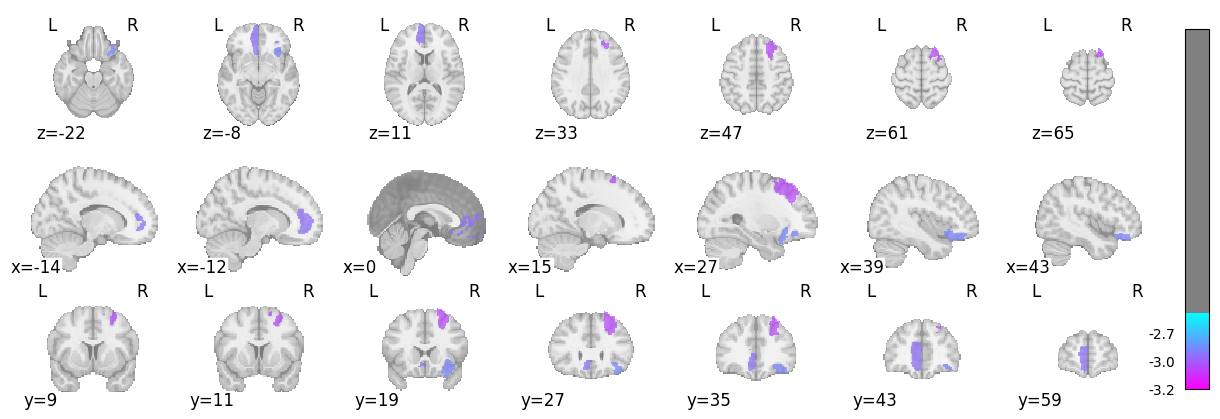

In [55]:
#create plots witt the t maps of the salience and default values in the brain
from templateflow.api import get
from nilearn.plotting import plot_roi, plot_anat    

cape = 'cape_PA_score'
seed = 'DRPutamen'

atlas_name = 'Schaefer2018'
desc_name = '100Parcels7Networks'

atlas_file = get('MNI152NLin2009cAsym',
resolution=2,
atlas= atlas_name,
desc= desc_name
)
# Load the atlas using nibabel
atlas = nib.load(atlas_file)

# Step 1: create zero image
masks = np.zeros(np.shape(atlas), dtype=np.float32)

# Step 2: Use the affine matrix from the atlas
affine = atlas.affine

atlas_data = atlas.get_fdata()  # Use get_fdata() instead of get_data()

for roi_id in rois_pa:

    # Step 3: Find the indices where the atlas has the ROI ID
    ix = np.where(atlas_data == roi_id)  # ROI ID in atlas

    t_value = results[f'{cape}'][roi_id]['t_value']
    if isinstance(t_value, pd.Series):  # If it's a Series, extract the first value
        t_value = t_value.iloc[0]
    t_value = float(t_value)  # Ensure it is a float

    # 4. Assign the t-value to the corresponding voxels in the mask
    masks[ix] = t_value

# Step 5: Create a NIfTI image using the modified zero_volume
tmap_affined = nib.Nifti1Image(masks, affine)

# Step 6: Plot the tmap in the brain
fig, ax = plt.subplots(figsize=(30/2.5, 10/2.5))  # Create a Matplotlib figure
display = plot_roi(
    tmap_affined,
    display_mode='mosaic',
    colorbar=True,
    vmin=-3.3,
    vmax=-2.5,
    cmap='cool_r',  # Color map for the t-map
    figure=fig  # Pass the Matplotlib figure
)

# Step 7: Customize the color bar
cbar = plt.gcf().get_axes()[-1]  # Get the color bar axis (last axis in the figure)
cbar.set_yticks([-3.3, -3, -2.7])  # Set custom tick values
cbar.set_yticklabels([ '-3.2', '-3.0', '-2.7'])  # Set custom tick labels

ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['left'].set_visible(False)  # Hide the left spine
ax.spines['bottom'].set_visible(False)  # Hide the bottom spine
ax.xaxis.set_ticks([])  # Hide x-axis ticks
ax.yaxis.set_ticks([])  # Hide y-axis ticks

# Show the plot
plt.show()

# reading all the data to plot ajust the data to the model

In [2]:
#importing the data from the csv file in the folder second_level_results
os.environ["ROOTDIR"] = r'C:\Users\angel\Documents\INPD_neuroimages_CAPE'  # seth path

workdir = os.environ["ROOTDIR"]
secondlvresults  = os.path.join(workdir,"second_level_results")

shaeffer_network = pd.read_csv('tpl-MNI152NLin2009cAsym_atlas-Schaefer2018_desc-100Parcels7Networks_dseg.tsv', delimiter='\t')
#extract the index with the name with SalVentAttn - salience network
salience_index = shaeffer_network[shaeffer_network['name'].str.contains('SalVentAttn')]
#extract the index with the name with Default - default mode network
default_index = shaeffer_network[shaeffer_network['name'].str.contains('Default')]

seednames = ['DCPutamen',
            'DorsalCaudate',
            'DRPutamen',
            'InfVentralCaudate',
            'SupVentralCaudate',
            'VRPutamen'
            ]



#stat a dictionary to store the salience and default values
results_all = {}

for cape in ['cape_PA_score', 'cape_tot', 'cape_BE_score', 'cape_PI_score']:
    results_all[cape] = {}
    for seed in seednames:
        results_all[cape][seed] = {}
        for roi in salience_index['index']:
            results_all[cape][seed][roi] = pd.read_csv(os.path.join(secondlvresults,f'{cape}-{seed}-roi_{roi}_2ndlvl.csv'), index_col=0)
        for roi in default_index['index']:
            results_all[cape][seed][roi] = pd.read_csv(os.path.join(secondlvresults,f'{cape}-{seed}-roi_{roi}_2ndlvl.csv'), index_col=0)

[np.float64(0.0913361898034738), np.float64(0.0900419376727735), np.float64(0.0910824931730727), np.float64(0.0899732478389395), np.float64(0.0899397339698983), np.float64(0.0903077871943023), np.float64(0.0948368481673417), np.float64(0.0903102437550261), np.float64(0.0900672885460992), np.float64(0.0899625244390799), np.float64(0.0907023324825906), np.float64(0.0960826331778231), np.float64(0.0927876991693557), np.float64(0.0981399622953589), np.float64(0.0910799277464268), np.float64(0.0955133771417539), np.float64(0.0907577808619617), np.float64(0.0920797508963391), np.float64(0.0920740756106296), np.float64(0.0963748458175839), np.float64(0.0961221722681507), np.float64(0.0901742037933184), np.float64(0.093024114011417), np.float64(0.0939360912999692), np.float64(0.1077048571827475), np.float64(0.092469617255781), np.float64(0.0924506933434226), np.float64(0.0907131268444869), np.float64(0.0924003509830903), np.float64(0.0952015890199662), np.float64(0.0899544097508996), np.float6

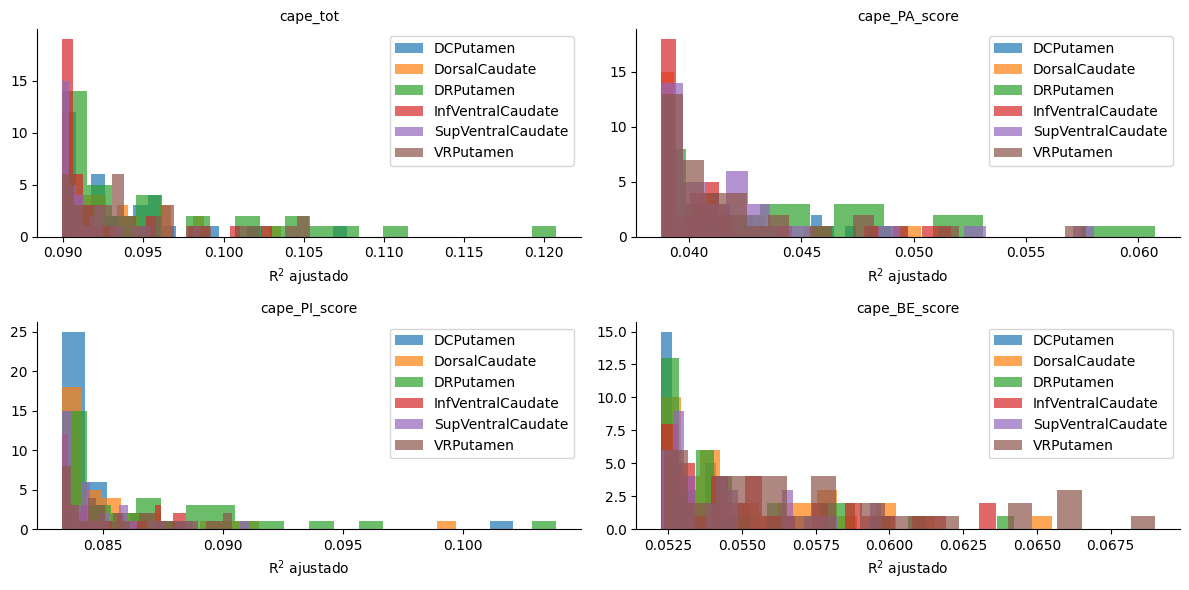

In [3]:
#make a histogram of R_squared values
plt.figure(figsize=(30/2.5 , 15/2.5))
# plt.title(f'R_squared values')
for idx, cape in enumerate(['cape_tot','cape_PA_score', 'cape_PI_score', 'cape_BE_score']):
    plt.subplot(2, 2, idx+1)
    plt.title(f'{cape}', fontsize=10)
    for seed in seednames:
        r_squared = []
        for roi in results_all[cape][seed].keys():
            r_squared.append(results_all[cape][seed][roi]['Adj_R_squared'].values[0])
        print(r_squared)

        plt.hist(
            r_squared, 
            bins=20,  
            alpha=0.7,
            label=f'{seed}')
        plt.legend()

    ax = plt.gca()  # Get the current axis
    ax.spines['top'].set_visible(False)  # Hide the top spine
    ax.spines['right'].set_visible(False)  # Hide the right spine
    plt.xlabel('R$^2$ ajustado')
    plt.tight_layout()


# Extra code may be removed

In [35]:
results['cape_PA_score'][44]['t_value'].values[0]

np.float64(0.3325292633790138)

In [12]:
print("Unique values in masks:", np.unique(masks))
for roi_id in [42, 43, 44, 46, 98, 99]:
    t_value = results['DRPutamen'][roi_id]['t_value']
    if isinstance(t_value, pd.Series):  # If it's a Series, extract the first value
        t_value = t_value.iloc[0]
    print(f"ROI ID: {roi_id}, t-value: {t_value}")

print("tmap_affined NIfTI image:")
print(tmap_affined)

print("Data type of masks:", masks.dtype)

Unique values in masks: [-3.768151  -3.070937  -2.7812254 -2.700595  -2.5691762 -2.5569675
  0.       ]
ROI ID: 42, t-value: -2.7812254846514595
ROI ID: 43, t-value: -2.700594788129746
ROI ID: 44, t-value: -3.768151010348268
ROI ID: 46, t-value: -2.5569673890631184
ROI ID: 98, t-value: -3.0709368752831216
ROI ID: 99, t-value: -2.5691762511472835
tmap_affined NIfTI image:

<class 'nibabel.nifti1.Nifti1Image'>
data shape (97, 115, 97)
affine:
[[   2.     0.    -0.   -96.5]
 [   0.     2.    -0.  -132.5]
 [   0.     0.     2.   -78.5]
 [   0.     0.     0.     1. ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 0
session_error   : 0
regular         : np.bytes_(b'')
dim_info        : 0
dim             : [  3  97 115  97   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix         

In [5]:
import statsmodels.formula.api as smf

shaeffer_network = pd.read_csv('tpl-MNI152NLin2009cAsym_atlas-Schaefer2018_desc-100Parcels7Networks_dseg.tsv', delimiter='\t')

#extract the index with the name with SalVentAttn - salience network
salience_index = shaeffer_network[shaeffer_network['name'].str.contains('SalVentAttn')]
#building my strign for the fomrula
formula_salience = 'cape_tot ~ '
for i in salience_index['index']:
    formula_salience += f'roi_{i} + '
formula_salience += '+ age + gender + abepscore + colection_site + fd_count_high_value'

#extract the index with the name with Default - default mode network
default_index = shaeffer_network[shaeffer_network['name'].str.contains('Default')]
#building my strign for the fomrula
formula_default = 'cape_tot ~ '
for i in default_index['index']:
    formula_default += f'roi_{i} + '
formula_default += '+ age + gender + abepscore + colection_site + fd_count_high_value'

results_salience, results_default = {}, {}

for seed in seednames:
    lala = tmap[seed].query('cape_tot != 0')

    results_salience[seed], results_default[seed] = {}, {}
    #print(f"Seed: {seed} - ROI: {roi}")
    model_salience = smf.ols(formula_salience, data=lala)
    results_salience[seed] = model_salience.fit()
    results_salience[seed] = results_salience[seed].summary()
    # results_salience[seed] = pd.read_html(results_salience[seed].tables[1].as_html(), header=0, index_col=0)[0]
    model_default = smf.ols(formula_default, data=lala)
    results_default[seed] = model_default.fit()
    results_default[seed] = results_default[seed].summary()
    # results_default[seed] = pd.read_html(results_default[seed].tables[1].as_html(), header=0, index_col=0)[0]


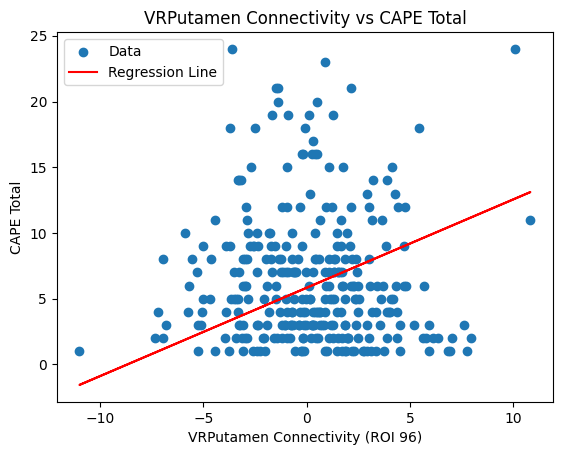

In [ ]:
plt.scatter(
    tmap['VRPutamen'].query('cape_tot!=0')['roi_39'], 
    tmap['VRPutamen'].query('cape_tot!=0')['cape_tot'], 
    label='Data'
)
plt.plot(
    tmap['VRPutamen'].query('cape_tot!=0')['roi_39'], 
    results_default['coef'].loc['roi_39'] * tmap['VRPutamen'].query('cape_tot!=0')['roi_39'] + results_default['coef'].loc['Intercept'], 
    color='red', 
    label='Regression Line'
)

# Add labels, title, and legend
plt.xlabel('VRPutamen Connectivity (ROI 39)')
plt.ylabel('CAPE Total')
plt.title('VRPutamen Connectivity vs CAPE Total')
plt.legend()

# Show the plot
plt.show()

In [39]:
salience['VRPutamen']['P>|t|']


Intercept              0.936
roi_24                 0.354
roi_25                 0.825
roi_26                 0.641
roi_27                 0.860
roi_28                 0.148
roi_29                 0.562
roi_30                 0.199
roi_74                 0.644
roi_75                 0.806
roi_76                 0.544
roi_77                 0.131
roi_78                 0.514
age                    0.764
gender                 0.003
abepscore              0.056
colection_site         0.000
fd_count_high_value    0.491
Name: P>|t|, dtype: float64